In [94]:
# Imports and such (remember to start the notebook in the same directory...)
# %matplotlib widget
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import scipy.special as scsp
import pandas as pd

import mit_olb.OLBtools as olb
import mit_olb.OLBtools.scintillation as scint


In [5]:
# Objectives
elevation_min = olb.radians(25)  #00 degrees
elevation_max = olb.radians(90)  #90 degrees

# Orbits
altitude    = 500e3 # spacecraft altitude

# Transmit
P_avg =  0.250          # Transmit power laser, W   | (EDFA output @ 24 dBm)
lambda_gl = 1550e-9     # Laser 1 wavelength, m     |
beam_width = 1e-3 / 0.8493       # beam width, FWMH radian   |

# Receive
aperture = 279e-3       # Aperture diameter, m
aperture_scaling = 0.70 # Fraction of clear aperture

# Detector (ignore for now)
apd_resp_vw = 340e3     # V.W-1
apd_resistance = 68e3   # Ohms
apd_NEP = 130e-15       # W / rtHz
apd_bandwidth = 40e6    # Hz

apd_responsivity = apd_resp_vw / apd_resistance     # A.W-1
apd_fn = 0.9      # Excess noise factor @M=100      | Taken backwards to match NEP
apd_dark_current = apd_NEP * apd_responsivity

# Losses
pointing_error = 0.3e-6   # radian
tx_system_loss = 1.00    # dB (10Log)
rx_system_loss = 4.00    # dB (10Log)

# Atmosphere
Cn2 = scint.Cn2_HV_57      # Hufnagel-valley 5/7 model

In [6]:
# Double check photodiode characteristics
# I cannot figure out how to get this to line up with our choice...
pd = olb.Photodiode(
    gain=1,
    responsivity=apd_responsivity,
    bandwidth=apd_bandwidth,
    excess_noise_factor=apd_fn,
    amp_noise_density=130e-15,
    dark_current=apd_dark_current)

pd.estimatedNEP()
# The estimated NEP ought to match roughly with the given NEP

2.6183178935955634e-14

In [ ]:
olb.degrees(elevation_max-elevation_min)*10 + 1

65.0

In [36]:
# Main calculation block

#500 points, from specified minimum elevation to top.
elevation = np.linspace(elevation_min,elevation_max, int(olb.degrees(elevation_max-elevation_min)*10 + 1))
zenith = np.pi/2-elevation
 
H = altitude
h_0 = 0

# Link range for elevation range
link_range = olb.slant_range(h_0,H,zenith,olb.Re)

# Misspointing as distance at receiver
r_s = np.tan(pointing_error)*link_range

# 1/e2 beam radius
W_0 = olb.fwhm_to_radius(beam_width,lambda_gl)

# Wavenumber
k = olb.angular_wave_number(lambda_gl)

range_loss = olb.path_loss_gaussian(W_0, lambda_gl, link_range, aperture, pointing_error)

all_losses = range_loss-tx_system_loss-rx_system_loss

# Expected value of the power at he receiver
Pe = aperture_scaling*P_avg*10**(all_losses/10)
Pe = Pe[:,np.newaxis] #on second dim

# Scintillation
sig2_x, sig2_y = scint.get_scintillation_downlink_xy(h_0,H,zenith,k,W_0,Cn2)
sig2_x = sig2_x[:,np.newaxis]
sig2_y = sig2_y[:,np.newaxis]

# Power distribution coeficients
alpha,mu,r =  scint.gamma_gamma_to_alpha_mu(sig2_x,sig2_y,orders=[2,3])

# Power log scale, must include 1% to 99% cumulated power
Hv = np.ceil(np.log10(scint.alpha_mu_inv_cdf(alpha,mu,r,Pe,0.01).max()))
Hl = np.floor(np.log10(scint.alpha_mu_inv_cdf(alpha,mu,r,Pe,0.99).min()))
Ps = np.logspace(Hl,Hv,500)
Psn = Ps[np.newaxis,:]#on second dim
# Sacle interval centers
pdfPs = (Ps[1:]+Ps[:-1])/2
dPs = Ps[1:]-Ps[:-1]
dPs = dPs[:,np.newaxis]

# Cumulative distribution function
cdfs = scint.alpha_mu_cdf(alpha,mu,r,Pe,Psn)
cdfst = cdfs.transpose()

# Prpablility densisty function, over log scale intervals
pdfst = cdfst[1:,:]-cdfst[:-1,:]


pdfPs = pdfPs[:,np.newaxis]

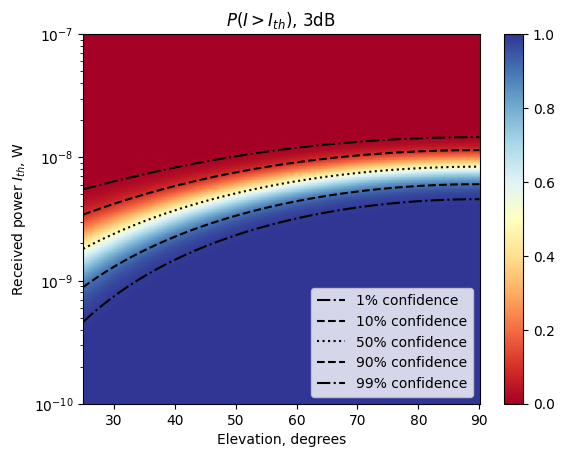

In [37]:
# Plot the received power distribution
def plt_1_distrib(sx,sy,psv,pev,pnv):
    alpha,mu,r =  scint.gamma_gamma_to_alpha_mu(sx,sy,orders=[2,3])
    cdfs = scint.alpha_mu_cdf(alpha,mu,r,pev,pnv)
    cdfst = cdfs.transpose()

    p01 = scint.alpha_mu_inv_cdf(alpha,mu,r,pev,0.01)
    p10 = scint.alpha_mu_inv_cdf(alpha,mu,r,pev,0.10)
    p50 = scint.alpha_mu_inv_cdf(alpha,mu,r,pev,0.50)
    p90 = scint.alpha_mu_inv_cdf(alpha,mu,r,pev,0.90)
    p99 = scint.alpha_mu_inv_cdf(alpha,mu,r,pev,0.99)

    plt.figure()
    plt.yscale('log')
    plt.pcolormesh(olb.degrees(elevation),psv, 1-cdfst, cmap = 'RdYlBu')
    plt.xlabel('Elevation, degrees')
    plt.ylabel('Received power $I_{th}$, W')
    # plt.plot(olb.degrees(elevation),pev,color='black',label='Without scintillation')
    plt.plot(olb.degrees(elevation),p01,color='black',linestyle='-.',label='1% confidence')
    plt.plot(olb.degrees(elevation),p10,color='black',linestyle='--',label='10% confidence')
    plt.plot(olb.degrees(elevation),p50,color='black',linestyle=':', label='50% confidence')
    plt.plot(olb.degrees(elevation),p90,color='black',linestyle='--',label='90% confidence')
    plt.plot(olb.degrees(elevation),p99,color='black',linestyle='-.',label='99% confidence')
    plt.ylim([psv[0],psv[-1]])
    plt.clim([0,1])
    plt.legend(loc=4)
    plt.colorbar()

    plt.title('$P(I>I_{th})$, 3dB')
    plt.ylim([Ps[0],Ps[-1]])

plt_1_distrib(sig2_x,sig2_y,Ps,Pe,Psn)
# plt.show()

In [93]:
elv_deg = olb.degrees(elevation)[0::50]
link_range = olb.slant_range(h_0,H,zenith,olb.Re)[0::50] / 1e3

p50_deg = scint.alpha_mu_inv_cdf(alpha,mu,r,Pe,0.50)[0::50][:,0]
p99_deg = scint.alpha_mu_inv_cdf(alpha,mu,r,Pe,0.99)[0::50][:,0]

db50_deg = 10 * np.log10(p50_deg / 1e-3)
db99_deg = 10 * np.log10(p99_deg / 1e-3)

# Stack columns
per_degree = np.column_stack([elv_deg, link_range, p50_deg / 1e-9, db50_deg, p99_deg / 1e-9, db99_deg])
pd.DataFrame(per_degree, columns=["Elevation, deg", "Link Range, km", "Pwr Rx (50%), nW", "Pwr Rx (50%), dBm", "Pwr Rx (99%), nW", "Pwr Rx (99%), dBm"])

,"Elevation, deg","Link Range, km","Pwr Rx (50%), nW","Pwr Rx (50%), dBm","Pwr Rx (99%), nW","Pwr Rx (99%), dBm"
0,25.0,1031.939376,1.808845,-57.425986,0.461253,-63.360607
1,30.0,909.502287,2.390979,-56.214242,0.741279,-61.300182
2,35.0,815.088756,3.029404,-55.186428,1.081504,-59.659718
3,40.0,741.326856,3.706447,-54.310422,1.469697,-58.327722
4,45.0,683.091532,4.402672,-53.562836,1.891131,-57.232783
5,50.0,636.790115,5.097666,-52.926287,2.329528,-56.327321
6,55.0,599.874488,5.770793,-52.387645,2.767884,-55.578521
7,60.0,570.516804,6.401921,-51.936897,3.189231,-54.963141
8,65.0,547.395046,6.972088,-51.566372,3.577323,-54.464419
9,70.0,529.550745,7.464110,-51.270220,3.917267,-54.070168
